# Exploratory Data Analysis

This notebook performs an initial EDA based on the sample data extracted during the data pull and etl steps.

In [1]:
import os
from os.path import join
import eland as ed
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

project_dir = join(os.getcwd(), os.pardir)
raw_dir = join(project_dir, 'data', 'raw')
interim_dir = join(project_dir, 'data', 'interim')
db_name = 'data_pull_sample.db'

%config InlineBackend.figure_format = 'svg'

In [2]:
ed_df = ed.read_es('localhost', 'twitter')
df_twt = ed_df.to_pandas()
df_users = df_twt.loc[
    :,
    list(df_twt.columns[df_twt.columns.str.startswith('user')]) + ['verified', 'protected']
].copy().drop_duplicates('user_id')

df_twt['is_original'] = ~df_twt[['is_retweet', 'is_quote_status', 'is_reply']].max(1)

## EDA Questions:
- How many tweets are in the dataset?
- How many unique tweets are in the dataset?
- How many unique users?
- Number of retweets
- Locate the top N retweeted and liked tweets and the users that posted them
- What are the locations? (Number of tweets by location)
- What are the main languages? What are the counts and proportions of tweets by languages?
- Location over time
- Source analysis
- Protected
- Verified

___
## Tweet Analysis
### How many tweets are in the dataset? How many unique tweets are in the dataset? Number of retweets?

In [3]:
print(f"""
Total number of Tweets:\t\t{df_twt.shape[0]}
Number of original Tweets:\t{df_twt.is_original.sum()}
Number of retweets:\t\t{df_twt.is_retweet.sum()}
Number of replies:\t\t{df_twt.is_reply.sum()}
Number of quotes:\t\t{df_twt.is_quote_status.sum()}

Note: Many of the quote statuses/tweets are both marked as quotes and retweets.
""")


Total number of Tweets:		455471
Number of original Tweets:	90726
Number of retweets:		346054
Number of replies:		14175
Number of quotes:		12815

Note: Many of the quote statuses/tweets are both marked as quotes and retweets.



### Locate the top N retweeted and liked tweets and the users that posted them

In [4]:
N = 20
df_twt[df_twt.is_original==True]\
    .nlargest(N, 'retweet_count')\
    [['tweet_id', 'full_text', 'retweet_count', 'name']]\
    .reset_index(drop=True)

,tweet_id,full_text,retweet_count,name
0,1263487665791352832,"Tomorrow, PM @narendramodi will travel to West...",8891,PMO India
1,1263788358343499776,"My prayers, thoughts &amp; love to those affec...",8728,Shah Rukh Khan
2,1263384064616103936,Have been seeing visuals from West Bengal on t...,8623,Narendra Modi
3,1263734564838465536,Speaking on the situation in the wake of Cyclo...,8594,Narendra Modi
4,1263383936706572288,My thoughts are with the people of Odisha as t...,8277,Narendra Modi
5,1264914357063831552,Spoke to PM Sheikh Hasina to wish her and the ...,6992,Narendra Modi
6,1263142031246778368,कोरोना संकट के बीच ‘अम्फान’ तूफान देश में आ रह...,6604,Priyanka Gandhi Vadra
7,1266310587585265664,"Kolkata, with unity comes strength and resilie...",6346,Shah Rukh Khan
8,1263383228586418176,We are closely monitoring the cyclone Amphan a...,3853,Amit Shah
9,1263871403146829824,Deeply saddened to know about the consequences...,3639,Honeypreet Insan


### What are the locations? (Number of tweets by location)

In [5]:
no_loc_count = df_twt['derived.locations.country'].isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain location info.""")

top_locations = df_twt.groupby('derived.locations.country')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'derived.locations.country':'Country'})\
    .set_index('Country')\
    .nlargest(20, 'Count')

top_locations

Please note that 452428 tweets (~99% of the dataset) do not contain location info.


,Count
Country,
India,2578
Equatorial Guinea,120
United States,83
Bangladesh,69
United Kingdom,46
Japan,32
Spain,12
Australia,9
Pakistan,8


### What are the main languages? What are the counts and proportions of tweets by languages?

In [6]:
no_loc_count = df_twt.lang.isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain tweet language info.""")

df_twt.groupby('lang')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'lang':'Language'})\
    .set_index('Language')\
    .nlargest(20, 'Count')

Please note that 5478 tweets (~1% of the dataset) do not contain tweet language info.


,Count
Language,
en,325704
hi,59696
bn,22292
und,10263
es,6559
or,4920
fr,3774
in,2267
de,1743


### Source analysis

In [7]:
no_loc_count = df_twt.source.isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain source info.""")

main_sources = {
    '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>': 'Android',
    '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>': 'Web',
    '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>': 'Web',
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone',
    '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>': 'iPad',
}

df_twt['main_sources'] = df_twt['source'].apply(
    lambda x: main_sources[x] 
    if x in main_sources.keys() 
    else 'Others/Unknown'
)

df_twt.groupby('main_sources')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'main_sources':'Source'})\
    .set_index('Source')\
    .nlargest(20, 'Count')

Please note that 0 tweets (~0% of the dataset) do not contain source info.


,Count
Source,
Android,291444
Web,67617
iPhone,50540
Others/Unknown,42209
iPad,3661


### Location over time

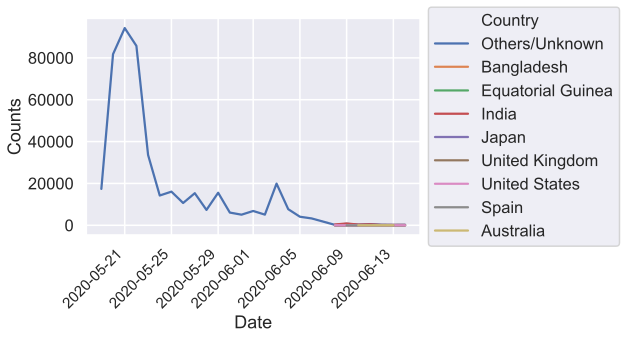

In [8]:
pd.options.mode.chained_assignment = None

top_locations_list = top_locations.iloc[:8]\
    .index.tolist()

df_places = df_twt[['tweet_created_at', 'derived.locations.country']]
df_places.loc[:,'created_at'] = pd.to_datetime(df_places.tweet_created_at).dt.date
df_places.loc[:,'derived.locations.country'] = df_places['derived.locations.country'].apply(
    lambda x: x 
    if x in top_locations_list
    else 'Others/Unknown'
)

df_places = df_places\
    .drop(columns='tweet_created_at')\
    .groupby(['created_at', 'derived.locations.country']).size()\
    .to_frame().reset_index()\
    .rename(columns={0:'Counts', 'derived.locations.country':'Country', 'created_at': 'Date'})\
    .sort_index()

sns.set(style="darkgrid", context="talk")
sns.lineplot(
    data=df_places, hue='Country', x='Date', y='Counts'
).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)


plt.show()

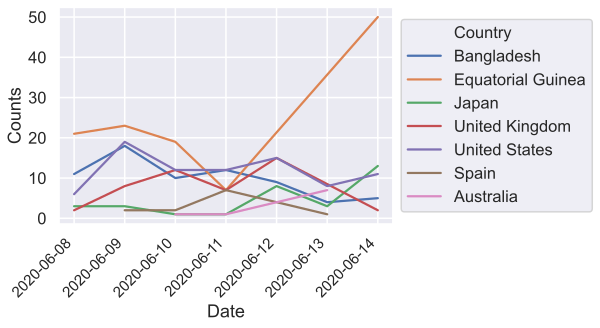

In [9]:
pd.options.mode.chained_assignment = None

top_locations_list = top_locations.iloc[:8]\
    .index.tolist()

df_places = df_twt[['tweet_created_at', 'derived.locations.country']]
df_places.loc[:,'created_at'] = pd.to_datetime(df_places.tweet_created_at).dt.date
df_places.loc[:,'derived.locations.country'] = df_places['derived.locations.country'].apply(
    lambda x: x 
    if x in top_locations_list
    else 'Others/Unknown'
)

df_places = df_places[~df_places['derived.locations.country'].isin(['Others/Unknown', 'India'])]

df_places = df_places\
    .drop(columns='tweet_created_at')\
    .groupby(['created_at', 'derived.locations.country']).size()\
    .to_frame().reset_index()\
    .rename(columns={0:'Counts', 'derived.locations.country':'Country', 'created_at': 'Date'})\
    .sort_index()

sns.set(style="darkgrid", context="talk")
sns.lineplot(
    data=df_places, hue='Country', x='Date', y='Counts'
).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)


plt.show()

### Based on User Location

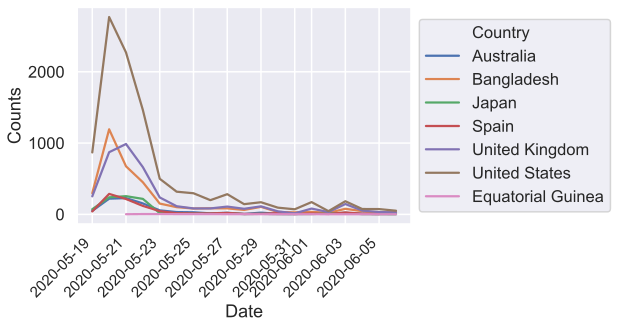

In [10]:
pd.options.mode.chained_assignment = None

top_locations_list = top_locations.iloc[:8]\
    .index.tolist()

df_places = df_twt[['tweet_created_at', 'users_derived_country']]
df_places.loc[:,'created_at'] = pd.to_datetime(df_places.tweet_created_at).dt.date
df_places.loc[:,'users_derived_country'] = df_places['users_derived_country'].apply(
    lambda x: x 
    if x in top_locations_list
    else 'Others/Unknown'
)

df_places = df_places[~df_places['users_derived_country'].isin(['Others/Unknown', 'India'])]

df_places = df_places\
    .drop(columns='tweet_created_at')\
    .groupby(['created_at', 'users_derived_country']).size()\
    .to_frame().reset_index()\
    .rename(columns={0:'Counts', 'users_derived_country':'Country', 'created_at': 'Date'})\
    .sort_index()

sns.set(style="darkgrid", context="talk")
sns.lineplot(
    data=df_places, hue='Country', x='Date', y='Counts'
).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)


plt.show()

___
## User Analysis
### How many unique users? Verified and Protected Users Analysis

In [11]:
print(f"""
Number of unique users: {df_users.drop_duplicates(subset='user_id').shape[0]}
Number of verified users: {df_users.verified.sum()}
Number of protected users: {df_users.protected.sum()}
""")


Number of unique users: 189441
Number of verified users: 3706
Number of protected users: 0

